In [1]:
# import requiered libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal, norm
import warnings
import random

# Mathematics behind GMM

**Step 01: Initialize mean, covariance and weight parameters**

1.   mean ($μ$): initialize randomly.
2.   covariance ($Σ$): initialize randomly.
3.   weight (mixing coefficients) ($π$): fraction per class refers to the likelihood that a particular data point belongs to each class. In the begining, this will be equal for all clusters. Assume that we fit a GMM with three components. In this case weight parameters might be set to 1/3 for each component, resulting in a probability distribution of (1/3, 1/3, 1/3).

**Step 02: Expectation Step (E step)**

For each data point $x_i$: Calculate the probability that the data point belongs to cluster ($c$) using the below equation. $K$ is the number of distribution we are supposed to find.

$$r_{i c}=\frac{\pi_c N\left(x_i \mid \mu_c, \Sigma_c\right)}{\Sigma_{k=1}^K \pi_k N\left(x_i \mid \mu_k, \Sigma_k\right)}$$

where $π_c$ is the mixing coefficient (sometimes called weight) for the Gaussian distribution c, which was initialized in the previous stage, and $N(x|μ,Σ)$ describe the probability density function (PDF) of a Gaussian distribution with mean $μ$ and covariance $Σ$ with respect to data point x; We can denote it as below.

$$N\left(x_i, \mu_c, \Sigma_c\right)=\frac{1}{(2 \pi)^{\frac{n}{2}}\left|\Sigma_c\right|^{\frac{1}{2}}} \exp \left(-\frac{1}{2}\left(x_i-\mu_c\right)^T \Sigma_c^{-1}\left(x_i-\mu_c\right)\right)$$

The E-step computes these probabilities using the current estimate of the model's parameters. These probabilities are typically referred to as the "responsibilities" of the Gaussian distributions. They are represented by the variable $r_{ic}$, where $i$ is the index of the data point, and $c$ is the index of the Gaussian distribution. The responsibility measure how much the c-th Gaussian distribution is responsible for generating the $i$-th data point. Conditional probability is used here, more specifically, Bayes theorem.

The result of the E-step is a set of responsibilities for each data point and each Gaussian distribution in the mixture model. These responsibilities are used in the M-step to update the estimates of the model's parameters.

**Step 03: Maximization Step (M step)**

In this step, the algorithm uses the responsibilities of the Gaussian distributions (computed in the E-step) to update the estimates of the model's parameters.

The M-step updates the estimates of the parameters as follows:

1.  $$\pi_c=\frac{\sum_{i=1}^m r_{i c}}{m}$$

where $m$ represents the number of data points

2.  $$\mu_c=\frac{\sum_{i=1}^m r_{i c} x_i}{\sum_{i=1}^m r_{i c}}$$


3.  $$\Sigma_c=\frac{\sum_{i=1}^m r_{i c}\left(x_i-\mu_c\right)^2}{\sum_{i=1}^m r_{i c}}$$




*   Update the $π_x$ (mixing coefficients) using the equation 1 above.
*   Update the $μ_c$ using equation 2 above.
*   Then update the $Σ_c$ using the 3rd equation.


Additional Fact:

$π_c$ can be considered equivalent to the fraction of points allocated to $c$ because numerator $Σ_i * r_{ic}$ represents the likelihood of the data point belonging to the gaussian $c$. If we assume we have 3 clusters and $i$-th data point belongs to cluster 1, we can write the related vector as $[0.97,0.02,0.01]$. If we sum these vectors for each data point, the result vector is approximately equal to the number of data points per cluster.

This updated estimate is used in the next E-step to compute new responsibilities for the data points.

So on and so forth, this process will repeat until algorithm convergence, typically achieved when the model parameters do not change significantly from one iteration to the next.





# Implementing GMM for the 1-D dataset

In [2]:
n_samples = 100
mu1, sigma1 = -5, 1.2
mu2, sigma2 = 5, 1.8
mu3, sigma3 = 0, 1.6

x1 = np.random.normal(loc=mu1, scale=np.sqrt(sigma1), size=n_samples)
x2 = np.random.normal(loc=mu2, scale=np.sqrt(sigma2), size=n_samples)
x3 = np.random.normal(loc=mu3, scale=np.sqrt(sigma3), size=n_samples)

X = np.concatenate((x1, x2, x3))

In [3]:
def plot_pdf(mu, sigma, label, alpha=0.5, linestyle='k--', density=True, color='green'):
  """
  Plot 1-D data and its PDF curve

  parameters
  -------------
  X: array-like, shape (n_samples, )
     The input data.
  """
  # plot the data
  X = norm.rvs(mu, sigma, size=1000)

  plt.hist(X, bins=50, density=density, alpha=alpha, label=label, color=color)

  # plot the PDF
  x = np.linspace(X.min(), X.max(), 1000)
  y = norm.pdf(x, mu, sigma)
  plt.plot(x, y, linestyle)

Please note that instead of plotting the data itself, I have plotted the probability density of each sample.

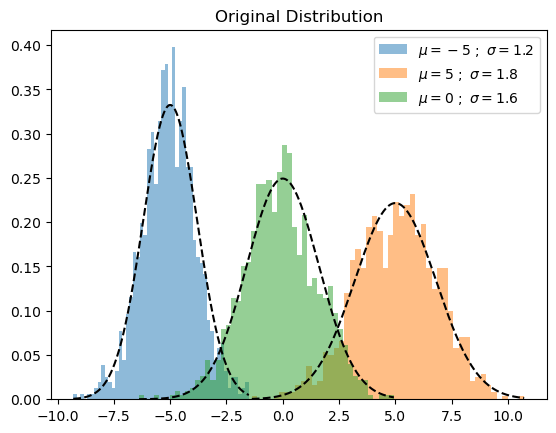

In [4]:
plot_pdf(mu1, sigma1, label=r'$\mu={} \ ; \ \sigma={}$'.format(mu1, sigma1), color=None)
plot_pdf(mu2, sigma2, label=r'$\mu={} \ ; \ \sigma={}$'.format(mu2, sigma2), color=None)
plot_pdf(mu3, sigma3, label=r'$\mu={} \ ; \ \sigma={}$'.format(mu3, sigma3), color=None)
plt.title('Original Distribution')
plt.legend()
plt.show()

Let's build each step described in the previous section.



**Step 01: Initialize mean, covariance, and weights**

In [5]:
def random_init(n_components):
  """Initialize means, weights and variance randomly."""

  pi = np.ones((n_components)) / n_components
  means = np.random.choice(X, n_components)
  variance = np.random.random_sample(size=n_components)
  plot_pdf(means[0], variance[0], 'Random Init 01',)
  plot_pdf(means[1], variance[1], 'Random Init 02', color='blue')
  plot_pdf(means[2], variance[2], 'Random Init 03', color='orange')

  plt.title('Random Initialization')

  plt.legend()
  plt.show()

  return means, variance, pi

**Step 02: Expectation Step (E step)**

In [6]:
def step_expectation(X, n_components, means, variances):
  """
  E-step

  Parameters
  ----------
  X: array-like shape (n_samples,)
     The data.

  n_components: int
     The number of clusters

  means: array-like, shape (n_components,)
     The means of each mixture component.

  variances: array-like, shape (n_components,)
     The variance of each mixture component.

  Returns
  -------
  weights: array-like, shape (n_components, n_samples)
  """

  weights = np.zeros((n_components, len(X)))
  for j in range(n_components):
    weights[j, :] = norm(loc=means[j], scale=np.sqrt(variances[j])).pdf(X)

  return weights

After this function, we covered the first two equations we discussed in E Step. Here we have generated the gaussian distribution for the current model parameter means and variances. We accomplished that by using the scipy's stat module. After, we used the pdf method to calculate the likelihood of belonging to each data point for each cluster.

**Step 03: Maximization Step (M step)**

In [7]:
def step_maximization(X, weights, means, variances, n_components, pi):
  """
  M-step

  Parameters
  ----------
  X: array-like, shape (n_samples,)
      The data.

  weights: array-like, shape (n_components, n_samples)
      initialized weights array

  means: array-like, shape (n_components,)
      The means of each mixture component.

  variances: array-like, shape (n_components,)
      The variances of each mixture component.

  n_components: int
      The number of clusters

  pi: array-like, shape (n_components,)
      mixture component weights

  Returns
  -------
  means: array-like, shape (n_components,)
      The means of each mixture component.

  variances: array-like, shape (n_components,)
      The variances of each mixture component.
  """

  r = []
  for j in range(n_components):
    r.append((weights[j] * pi[j]) / (np.sum([weights[i] * pi[i] for i in range(n_components)], axis=0)))

    means[j] = np.sum(r[j] * X) / (np.sum(r[j]))
    variances[j] = np.sum(r[j] * np.square(X - means[j])) / (np.sum(r[j]))

    pi[j] = np.mean(r[j])

  return variances, means, pi

In [8]:
def plot_intermediate_steps(means, variances, density=False, save=False, file_name=None):

  plot_pdf(mu1, sigma1, alpha=0.0, linestyle='r--', label='Original Distributions')
  plot_pdf(mu2, sigma2, alpha=0.0, linestyle='r--', label='Original Distributions')
  plot_pdf(mu3, sigma3, alpha=0.0, linestyle='r--', label='Original Distributions')

  color_gen = (x for x in ['green', 'blue', 'orange'])

  for mu, sigma in zip(means, variances):
    plot_pdf(mu, sigma, alpha=0.5, label='d', color=next(color_gen))

  if save or file_name is not None:
    step = file_name.split('_')[1]
    plt.title(f'step: {step}')
    plt.savefig(f'steps/{file_name}.png', bbox_inches='tight')

  plt.show()

In [9]:
def train_gmm(data, n_components=3, n_steps=50, plot_intermediate_steps_flag=True):
  """
  Training step of the GMM model

  Parameters
  ----------
  data: array-like, shape (n_samples,)
      The data.
  n_components: int
      The number of clusters
  n_steps: int
      number of iterations to run
  """

  means, variances, pi = random_init(n_components)
  for step in range(n_steps):
    weights = step_expectation(data, n_components, means, variances)
    variances, means, pi = step_maximization(data, weights, means, variances, n_components, pi)

    if plot_intermediate_steps_flag:
      plot_intermediate_steps(means, variances,)

  plot_intermediate_steps(means, variances)

In the below diagrams, red dashed lines represent the original distribution, while other graphs represent the learned distributions.

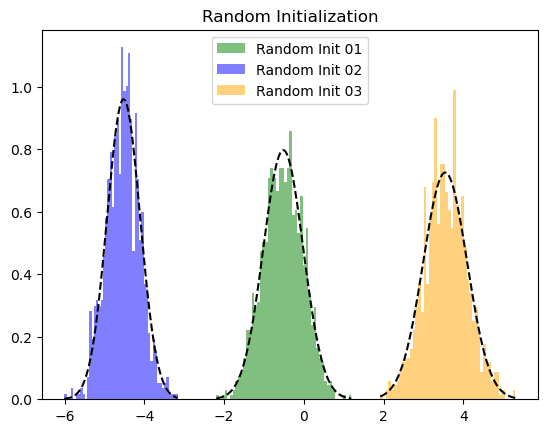

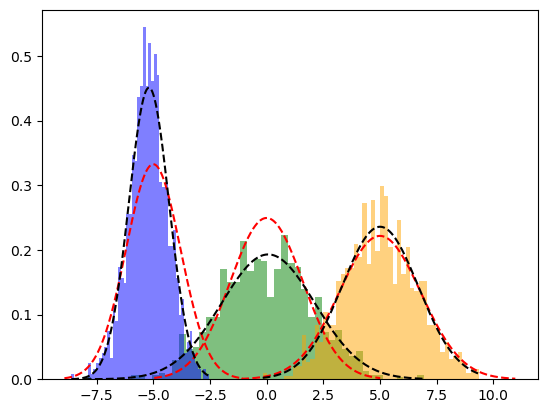

In [10]:
train_gmm(X, n_steps=50, plot_intermediate_steps_flag=False)